In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import scipy.stats


#additional imports for the models
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

%matplotlib inline

from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
data =  pd.read_csv('sis_cio_only_1277_records_one_hot_features_included_combined_train_and_test_sets.csv')
new_test = pd.read_csv('./2018-07-24_through_2018-08-17_sis_arff_files/sis_cio_only_194_records_one_hot_features_included_test_set.csv')

#### Shuffle Data 

In [3]:
data = data.sample(frac=1)
new_test = new_test.sample(frac=1)
y_test = new_test["label"]
X_test = new_test.iloc[:, data.columns != "label"]
y_train = data["label"]
X_train = data.iloc[:, data.columns != "label"]

In [4]:
xcols =  data.columns[data.columns != 'label']
data[data.index == 3]

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,label
3,0.465482,0.213868,0.0,0.0,0.0,0.0,2.0,3.0,0.994924,0.0,...,0,0,0,0,0,0,0,0,0,1


#### Helper Functions 

In [5]:
def getBestThreshold(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr),  index=i), 'threshold' : pd.Series(threshold, index=i)})
    ## 1-fpr = tnr , best threshold at tpr - tnr at minimum
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    print(roc_t['threshold'].values)
    return roc_t['threshold'].values

def get_predictions(ypredp, y_test, thr=None ):
    y_pred_df = pd.DataFrame( { 'actual': y_test,
                               "predicted_prob": ypredp } )
    sns.distplot( y_pred_df[y_pred_df.actual == 1]["predicted_prob"], hist=False, color = 'r' )
    sns.distplot( y_pred_df[y_pred_df.actual == 0]["predicted_prob"], hist=False, color = 'g' )
    
    if thr:
        sns.distplot( y_pred_df[y_pred_df.actual == 1]["predicted_prob"], hist=False, color = 'r' )
        sns.distplot( y_pred_df[y_pred_df.actual == 0]["predicted_prob"], hist=False, color = 'g' )
        plt.axvline(thr, color='blue', linestyle='dashed', linewidth=2)
        plt.axvline(0.5, color='black', linestyle='dashed', linewidth=2)
    
def get_tpr_tnr(y_test, ypred):
    TN, FP, FN, TP  = mt.confusion_matrix(y_test, ypred).ravel()
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print("TPR", TPR, "TNR", TNR, TPR/TNR)
    
def get_outliers(pdcolumn):
    mean = np.mean(pdcolumn, axis=0)
    sd = np.std(pdcolumn, axis=0)
    # print("Mean is {1} with Std. Deviation of {0}, \
    # lower outliers cutoff {2} and upper outlier cutoff {3}".format(sd,mean, (mean - (1.8 * sd)), (mean + (2.5 * sd))), "\n")
    final_list = [x for x in pdcolumn if (x < (mean - (2 * sd)))]
    final_list += [x for x in pdcolumn if (x > (mean + (2 * sd)))]
    return len(final_list), sorted(final_list), 


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    print("mean metric", m , "standard error", se)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return [m-h, m, m+h]

class_names = [0,1]
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


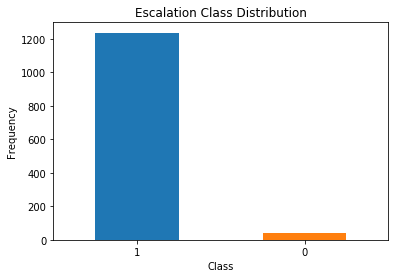

In [6]:
count_classes = pd.value_counts(data['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Escalation Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");



#### Generate synthetic samples for do-not-escalate-class

In [7]:
sm = SMOTE(random_state=2, ratio=.5, kind='svm')
Xs_train, ys_train = sm.fit_sample(X_train, y_train.ravel())
Xs_train = pd.DataFrame(Xs_train)
Xs_train.columns = X_train.columns 

In [8]:
dn_idx = Xs_train[ys_train == 0].index

In [9]:
Xus_train = Xs_train.iloc[dn_idx,:]
Xus_train.columns = X_train.columns 
Xus_train["label"] = ys_train[dn_idx]


#### Undersample 

In [10]:
print("Before UnderSampling, counts of label '0': {}".format(sum(data['label']==0)))
print("Before UnderSampling, counts of label '1': {} \n".format(sum(data['label']==1)))

all_do_not_esc = data[data['label'] == 0].reset_index()
all_esc = data[data['label'] == 1]

cols = all_esc[all_esc.columns[all_esc.dtypes == 'int64']].iloc[:,:-1].columns
#all_esc[cols] = all_esc[cols].astype(float)

data_undersampled = pd.concat([all_esc.sample(frac=.25),Xus_train])

yu_train = data_undersampled["label"]
Xu_train = data_undersampled.iloc[:, data_undersampled.columns != "label"]

#flip signs, make do-not-escalate class of interest
#print(y.sum())
#yu_test = yu_test.apply(lambda x: 0 if x==1 else 1 )

print("After UnderSampling, counts of label '1': {}".format(sum(yu_train==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(yu_train==0)))
Xuo_train = pd.DataFrame(Xu_train).copy()

Before UnderSampling, counts of label '0': 40
Before UnderSampling, counts of label '1': 1237 

After UnderSampling, counts of label '1': 309
After UnderSampling, counts of label '0': 312


In [11]:
cols

Index(['feature102', 'feature103', 'feature104', 'feature105', 'feature106',
       'feature107', 'feature108', 'feature109', 'feature110', 'feature111',
       ...
       'feature227', 'feature228', 'feature229', 'feature230', 'feature231',
       'feature232', 'feature233', 'feature234', 'feature235', 'feature236'],
      dtype='object', length=135)

#### Oversampled Dataset

In [12]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2, ratio=1, kind='svm')
Xs_train, ys_train = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(Xs_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(ys_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(ys_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(ys_train==0)))

Xs_train = pd.DataFrame(Xs_train)
ys_train = pd.Series(ys_train.ravel())
Xs_train.columns = xcols

Before OverSampling, counts of label '1': 1237
Before OverSampling, counts of label '0': 40 

After OverSampling, the shape of train_X: (1840, 237)
After OverSampling, the shape of train_y: (1840,) 

After OverSampling, counts of label '1': 1237
After OverSampling, counts of label '0': 603


#### Scale Data

In [13]:
rs = StandardScaler()
X_train = pd.DataFrame(rs.fit_transform(X_train), columns=xcols).copy()
Xs_train = pd.DataFrame(rs.fit_transform(Xs_train), columns=xcols).copy()
Xu_train = pd.DataFrame(rs.fit_transform(Xu_train), columns=xcols).copy()
X_test = pd.DataFrame(rs.fit_transform(X_test), columns=xcols)



mx = MinMaxScaler()
X_train_mx = pd.DataFrame(mx.fit_transform(X_train), columns=xcols).copy()
Xs_train_mx = pd.DataFrame(mx.fit_transform(Xs_train), columns=xcols).copy()
Xu_train_mx = pd.DataFrame(mx.fit_transform(Xu_train), columns=xcols).copy()
X_test_mx = pd.DataFrame(mx.fit_transform(X_test), columns=xcols)

#### Flip labels for convinience 

In [14]:
y_train = y_train.apply(lambda x: 0 if x==1 else 1 )
ys_train = ys_train.apply(lambda x: 0 if x==1 else 1 )

y_test = y_test.apply(lambda x: 0 if x==1 else 1 )
yu_train = yu_train.apply(lambda x: 0 if x==1 else 1 )

In [15]:
X_train.shape, X_test.shape

((1277, 237), (194, 237))

In [16]:
xgb = XGBClassifier()

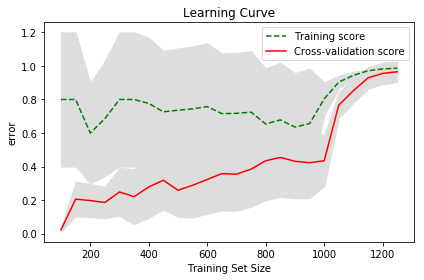

In [410]:
from sklearn import linear_model
skf = StratifiedKFold(n_splits=5)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(xgb, 
                                                        Xs_train, 
                                                        ys_train,
                                                        cv= skf,
                                                        # Evaluation metric
                                                        scoring='recall',
                                                        n_jobs=-1, 
                                                        train_sizes=list(range(100, 1300, 50)))

# Create means and standard deviations of training set scores
train_scores = abs(train_scores)
test_scores = abs(test_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="g",  label="Training score")
plt.plot(train_sizes, test_mean, color="r", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

####  High chances of overfitting the training samples when the dataset is small. As the dataset size grows, classifier starts to generalize better, performing better on test set.

#### Statistical Confidence_interval for algorithm performance

In [411]:
mean_confidence_interval(test_mean)

mean metric 0.42890438475665754 standard error 0.05415174196568249


[0.3168829716219003, 0.42890438475665754, 0.5409257978914148]

In [74]:
dic_weight = {1:len(yu_train)/(1*np.sum(yu_train)), 0:len(yu_train)/(len(yu_train)-1*np.sum(yu_train))}

In [76]:
lg = linear_model.LogisticRegressionCV(random_state=2111, penalty="l2", Cs=[0.01,0.14, 100], class_weight=dic_weight)
lg.fit(Xs_train, ys_train)

LogisticRegressionCV(Cs=[0.01, 0.14, 100],
           class_weight={1: 1.9903846153846154, 0: 2.0097087378640777},
           cv=None, dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=2111, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [77]:
ypred = lg.predict(X_test)

print(roc_auc_score(y_test, ypred), "\n")
print(mt.confusion_matrix(y_test, ypred), "TN, FP, FN, TP")
print(mt.classification_report(y_test, ypred))
print(get_tpr_tnr(y_test, ypred))

0.4920634920634921 

[[186   3]
 [  5   0]] TN, FP, FN, TP
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       189
          1       0.00      0.00      0.00         5

avg / total       0.95      0.96      0.95       194

TPR 0.0 TNR 0.9841269841269841 0.0
None


In [78]:
ypredp = lg.predict_proba(X_test)[:,1]
cutoff = getBestThreshold(y_test,ypredp)

[0.04]


In [79]:
f = lambda x: 1 if x > cutoff else 0
ypcls = np.fromiter((f(xi) for xi in ypredp), ypredp.dtype, count=len(ypredp))

confusion_matrix(y_test, ypcls)

print("roc-auc", roc_auc_score(y_test, ypcls))
print(mt.classification_report(y_test, ypcls))
print(mt.confusion_matrix(y_test, ypcls), "TN, FP, FN, TP")

roc-auc 0.5936507936507937
             precision    recall  f1-score   support

          0       0.98      0.59      0.74       189
          1       0.04      0.60      0.07         5

avg / total       0.96      0.59      0.72       194

[[111  78]
 [  2   3]] TN, FP, FN, TP


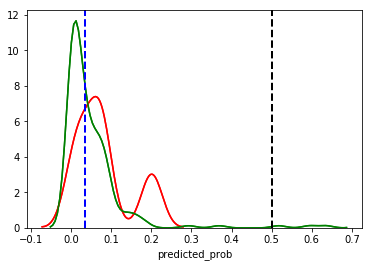

In [80]:
get_predictions(lg.predict_proba(X_test)[:,1], y_test, thr=cutoff)

In [81]:
get_tpr_tnr(y_test, ypcls)

TPR 0.6 TNR 0.5873015873015873 1.0216216216216216


In [82]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [5 , 10, 20, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 300, 500, 600]}

In [83]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter=5, scoring='roc_auc', n_jobs=4, cv=3, verbose=1, random_state=2111 )

# Fit the random search model
rf_random.fit(Xs_train, ys_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    4.0s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=4,
          param_distributions={'bootstrap': [True, False], 'max_depth': [5, 10, 20, 30, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 300, 500, 600]},
          pre_dispatch='2*n_jobs', random_state=2111, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [84]:
(rf_random.best_params_.keys(), rf_random.best_params_.values())

(dict_keys(['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'bootstrap']),
 dict_values([500, 10, 1, 'sqrt', 20, True]))

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(bootstrap=True, max_depth= 20, max_features= 'sqrt', min_samples_leaf = 1,\
                            min_samples_split = 10, n_estimators = 500)

rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

print(roc_auc_score(y_test, ypred), "\n")
print(mt.classification_report(y_test, ypred))

0.5 

             precision    recall  f1-score   support

          0       0.97      1.00      0.99       189
          1       0.00      0.00      0.00         5

avg / total       0.95      0.97      0.96       194



In [89]:
ypredp = rf.predict_proba(X_test)[:,1]
cutoff = getBestThreshold(y_test,ypredp)


f = lambda x: 1 if x > cutoff else 0
ypcls = np.fromiter((f(xi) for xi in ypredp), ypredp.dtype, count=len(ypredp))

confusion_matrix(y_test, ypcls)

print("roc-auc", roc_auc_score(y_test, ypcls))
print(mt.classification_report(y_test, ypcls))
print(mt.confusion_matrix(y_test, ypcls))

[0.01]
roc-auc 0.446031746031746
             precision    recall  f1-score   support

          0       0.97      0.49      0.65       189
          1       0.02      0.40      0.04         5

avg / total       0.94      0.49      0.64       194

[[93 96]
 [ 3  2]]


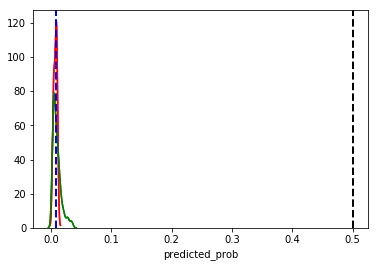

In [90]:
get_predictions(rf.predict_proba(X_test)[:,1], y_test, thr=cutoff)

In [91]:
get_tpr_tnr(y_test, ypcls)

TPR 0.4 TNR 0.49206349206349204 0.8129032258064517


In [92]:
# A parameter grid for XGBoost
eval_set = [(X_test, y_test)]
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.01, 0.02, 0.1],
        'max_depth': [2, 3, 4, 5, 8],
        'n_estimators': [100, 200,300, 500],
        }

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=4, scoring='roc_auc', n_jobs=4, cv=3, verbose=2, random_state=2111 )

In [229]:
random_search.fit(Xs_train, ys_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] subsample=0.6, n_estimators=500, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV] subsample=0.6, n_estimators=500, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV] subsample=0.6, n_estimators=500, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV] subsample=0.8, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.01, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.01, gamma=2, colsample_bytree=1.0, total=   4.0s
[CV] subsample=0.8, n_estimators=300, min_child_weight=10, max_depth=5, learning_rate=0.01, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=500, min_child_weight=1, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   5.1s
[CV] subsample=0.8, n_estimators=300, min_child_weight=10

[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   11.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=4, n_jobs=4,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'learning_rate': [0.01, 0.02, 0.1], 'max_depth': [2, 3, 4, 5, 8], 'n_estimators': [100, 200, 300, 500]},
          pre_dispatch='2*n_jobs', random_state=2111, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [230]:
(len(y_test) - y_test.sum())/ y_test.sum()
#sum(negative instances) / sum(positive instances)

37.8

In [231]:
str(random_search.best_params_).replace(":", "=").replace("'","")

'{subsample= 0.6, n_estimators= 500, min_child_weight= 1, max_depth= 4, learning_rate= 0.1, gamma= 1, colsample_bytree= 0.8}'

In [264]:
xgb1 = XGBClassifier(subsample= 0.6, n_estimators= 400, min_child_weight= 1,
                     max_depth= 2, learning_rate= 0.1, gamma= 1, colsample_bytree= .8)
xgb1.fit(pd.DataFrame(Xs_train), ys_train)

ypred = xgb1.predict(pd.DataFrame(X_test))
print(roc_auc_score(y_test, ypred))
print(mt.classification_report(y_test, ypred))
print(mt.confusion_matrix(y_test, ypred)) 

0.48677248677248675
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       189
          1       0.00      0.00      0.00         5

avg / total       0.95      0.95      0.95       194

[[184   5]
 [  5   0]]


In [265]:
get_tpr_tnr(y_test, ypred)

TPR 0.0 TNR 0.9735449735449735 0.0


In [266]:
ypredp = xgb1.predict_proba(pd.DataFrame(X_test))[:,1]
cutoff = getBestThreshold(y_test,ypredp)

[0.12]


In [267]:
f = lambda x: 1 if x > cutoff else 0
ypcls = np.fromiter((f(xi) for xi in ypredp), ypredp.dtype, count=len(ypredp))


# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, ypcls)
print(roc_auc_score(y_test, ypcls))
print(mt.classification_report(y_test, ypcls))
print(mt.confusion_matrix(y_test, ypcls)) 

0.8126984126984127
             precision    recall  f1-score   support

          0       0.99      0.83      0.90       189
          1       0.11      0.80      0.19         5

avg / total       0.97      0.82      0.88       194

[[156  33]
 [  1   4]]


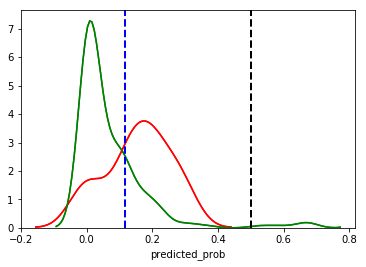

In [268]:
get_predictions(ypredp, y_test, thr=cutoff )

In [269]:
get_tpr_tnr(y_test, ypcls)

TPR 0.8 TNR 0.8253968253968254 0.9692307692307693


#### New approach

Since the number of positive/class of interest has low number of examples, I would be interesting to see if there is any clustering. If there is, distance based/clustering algorithms can be explored

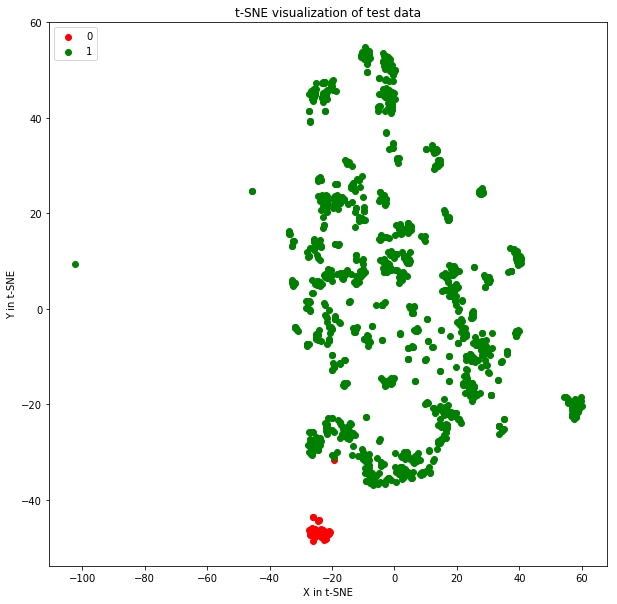

In [44]:
df2 = data[data.label == 1]
df2 = pd.concat([df2, data[data.label == 0]], axis = 0)

#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.ix[:,-1].values

tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

#Build the scatter plot with the two types of events.
color_map = {0:'red', 1:'green'}
plt.figure(figsize=(10,10))
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()



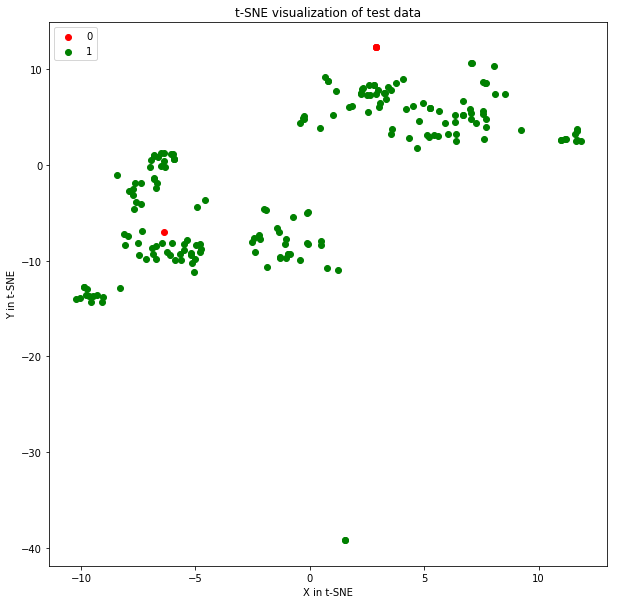

In [45]:
df2 = new_test[new_test.label == 1]
df2 = pd.concat([df2, new_test[new_test.label == 0]], axis = 0)

#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df2_std = standard_scaler.fit_transform(df2)

#Set y equal to the target values.
y = df2.ix[:,-1].values

tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df2_std)

#Build the scatter plot with the two types of events.
color_map = {0:'red', 1:'green'}
plt.figure(figsize=(10,10))
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()


at threshold 0.1 -> Recall:0.6 , roc_auc 0.5275132275132275
at threshold 0.2 -> Recall:0.6 , roc_auc 0.5513227513227513
at threshold 0.3 -> Recall:0.6 , roc_auc 0.5724867724867725
at threshold 0.4 -> Recall:0.6 , roc_auc 0.5857142857142856
at threshold 0.5 -> Recall:0.6 , roc_auc 0.6068783068783069
at threshold 0.6 -> Recall:0.6 , roc_auc 0.6227513227513228
at threshold 0.7 -> Recall:0.6 , roc_auc 0.6597883597883598
at threshold 0.8 -> Recall:0.6 , roc_auc 0.7153439153439154
at threshold 0.98 -> Recall:0.2 , roc_auc 0.5603174603174603


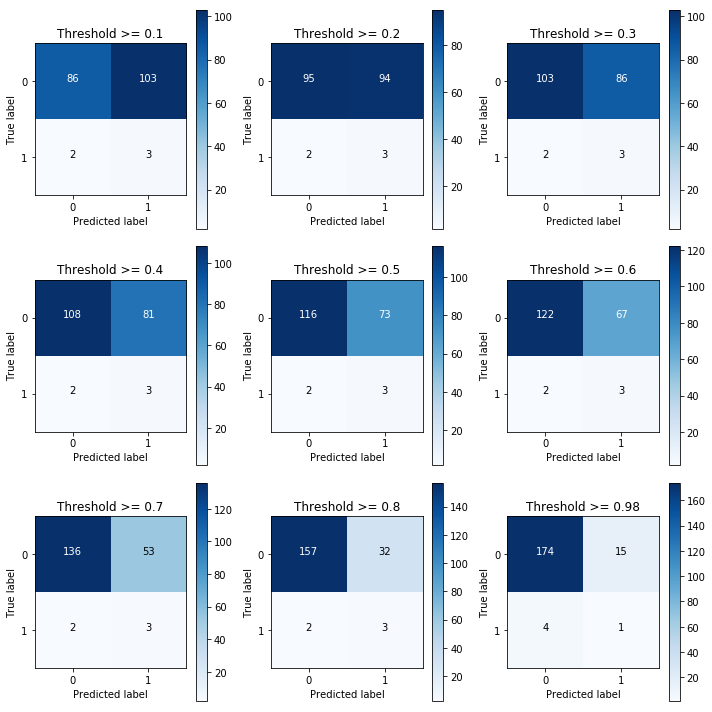

In [384]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(Xs_train, ys_train) 

y_pred_proba = neigh.predict_proba(X_test.values)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,.98]
plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_tp = y_pred_proba[:,1] > i
    plt.subplot(3,3,j)
    j += 1
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_tp)
    np.set_printoptions(precision=2)
    print("at threshold {} -> Recall:{} , roc_auc {}".format(i, cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]), roc_auc_score(y_test, y_tp)))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)

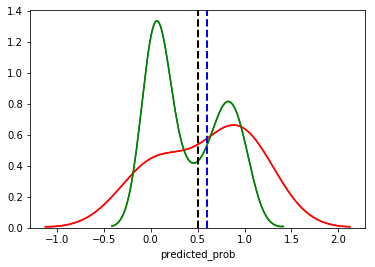

In [149]:
get_predictions(y_pred_proba[:,1], y_test, thr=.6)

In [150]:
get_tpr_tnr(y_test, y_pred_proba[:,1] >.6)

TPR 0.6 TNR 0.6455026455026455 0.9295081967213115


#### Model with undersampled majority class data! 

at threshold 0.1 -> Recall:0.2 , roc_auc 0.5523809523809523
at threshold 0.2 -> Recall:0.2 , roc_auc 0.5867724867724867
at threshold 0.3 -> Recall:0.0 , roc_auc 0.4894179894179894
at threshold 0.4 -> Recall:0.0 , roc_auc 0.4920634920634921
at threshold 0.5 -> Recall:0.0 , roc_auc 0.4920634920634921
at threshold 0.6 -> Recall:0.0 , roc_auc 0.4973544973544973
at threshold 0.7 -> Recall:0.0 , roc_auc 0.5
at threshold 0.8 -> Recall:0.0 , roc_auc 0.5
at threshold 0.9 -> Recall:0.0 , roc_auc 0.5


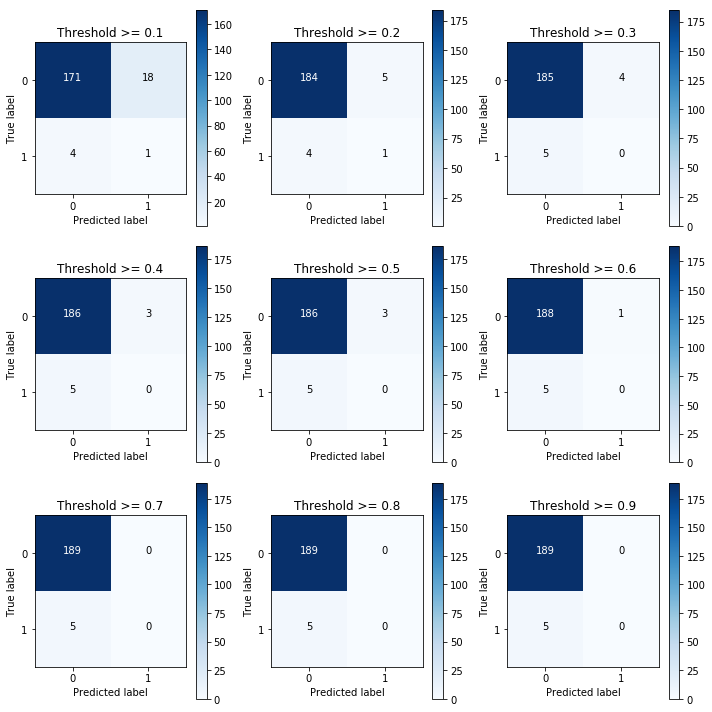

In [385]:
lrl = linear_model.LogisticRegression(C = 10, penalty = 'l1')
lrl.fit(Xu_train,yu_train)
y_pred_proba = lg.predict_proba(X_test.values)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_tp = y_pred_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_tp)
    np.set_printoptions(precision=2)
    print("at threshold {} -> Recall:{} , roc_auc {}".format(i, cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]), roc_auc_score(y_test, y_tp)))
    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)

#### With oversampled minority class data


 at threshold 0.1 -> Recall:0.2 , roc_auc 0.5523809523809523

 at threshold 0.2 -> Recall:0.2 , roc_auc 0.5867724867724867

 at threshold 0.3 -> Recall:0.0 , roc_auc 0.4894179894179894

 at threshold 0.4 -> Recall:0.0 , roc_auc 0.4920634920634921

 at threshold 0.5 -> Recall:0.0 , roc_auc 0.4920634920634921

 at threshold 0.6 -> Recall:0.0 , roc_auc 0.4973544973544973

 at threshold 0.7 -> Recall:0.0 , roc_auc 0.5

 at threshold 0.8 -> Recall:0.0 , roc_auc 0.5

 at threshold 0.9 -> Recall:0.0 , roc_auc 0.5


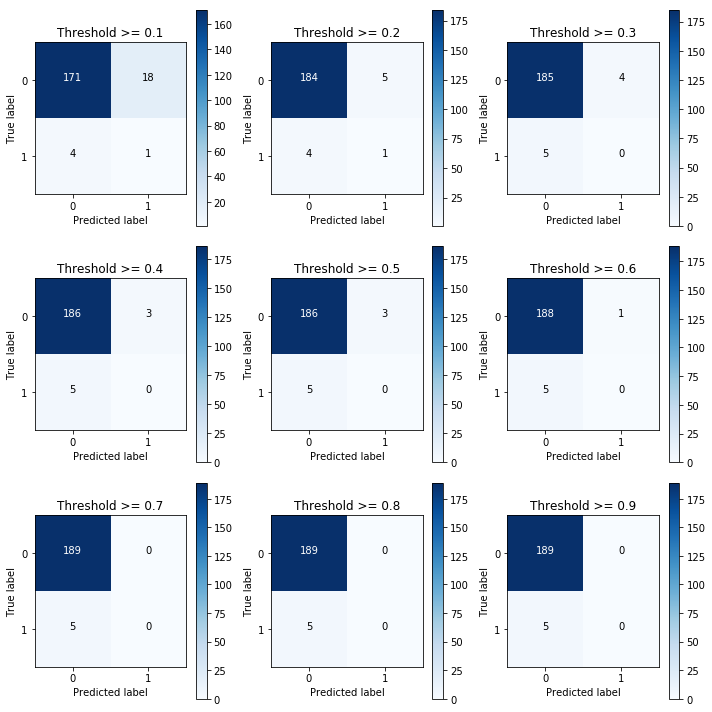

In [152]:
lru = linear_model.LogisticRegression(C = 10, penalty = 'l2')
lru.fit(Xs_train,ys_train)
y_pred_proba = lg.predict_proba(X_test.values)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_tp = y_pred_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_tp)
    np.set_printoptions(precision=2)
    print("\n at threshold {} -> Recall:{} , roc_auc {}".format(i, cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]), roc_auc_score(y_test, y_tp)))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)

#### Both perform similarly, even though undersampled model has 1/3 of the data

In [367]:
from sklearn.ensemble import VotingClassifier
dic_weight = {1:len(y)/(1*np.sum(y)), 0:len(y)/(len(y)-1*np.sum(y))} 

"""eclf2 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', neigh), ('xgb',xgb1)],
        voting='soft', weights=[.5,.5,2.5])"""

eclf2 = VotingClassifier(estimators=[
        ('lr', rf), ('knn', neigh), ('xgb',xgb1)],
        voting='soft', weights=[0.0,0.1,2.5])

#roc
#[.5,.5,2.5] .8
#[.5,2.5,2] .65
#[.5,2,2] .71
#[.5,2,1] .72
#[.5,2,.7] .67
#[0.2,0.08,1.4] .75

#[0.1,0.05,1.4] .81


eclf2 = eclf2.fit(pd.DataFrame(Xs_train), ys_train)

 at threshold 0.1 -> Recall:0.8 , roc_auc 0.7439153439153441
 at threshold 0.2 -> Recall:0.4 , roc_auc 0.6444444444444444
 at threshold 0.3 -> Recall:0.2 , roc_auc 0.5788359788359788
 at threshold 0.4 -> Recall:0.0 , roc_auc 0.48677248677248675
 at threshold 0.5 -> Recall:0.0 , roc_auc 0.48677248677248675
 at threshold 0.6 -> Recall:0.0 , roc_auc 0.4920634920634921
 at threshold 0.7 -> Recall:0.0 , roc_auc 0.5
 at threshold 0.8 -> Recall:0.0 , roc_auc 0.5
 at threshold 0.9 -> Recall:0.0 , roc_auc 0.5


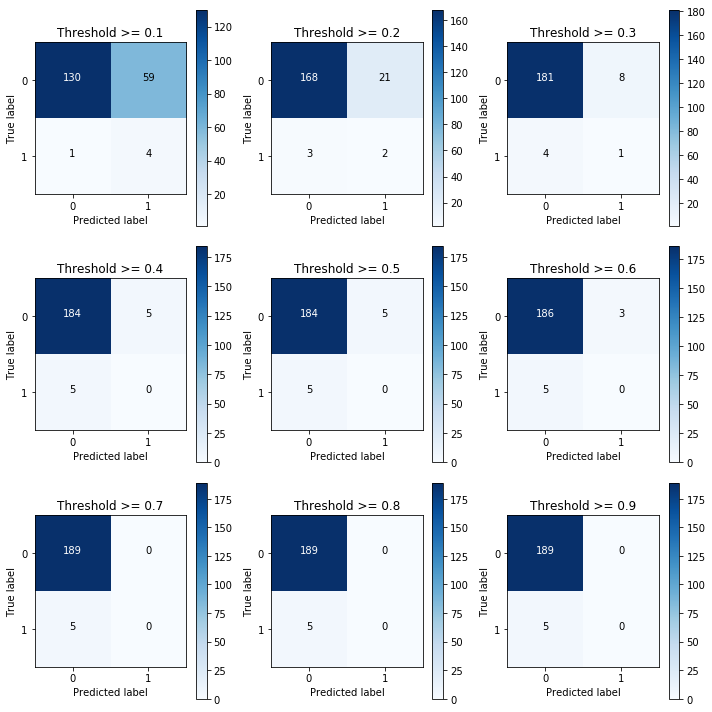

In [368]:
y_pred_proba = eclf2.predict_proba(X_test)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_tp = y_pred_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_tp)
    np.set_printoptions(precision=2)
    print(" at threshold {} -> Recall:{} , roc_auc {}".format(i, cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]), roc_auc_score(y_test, y_tp)))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)

In [369]:
cutoff = getBestThreshold(y_test,eclf2.predict_proba(pd.DataFrame(X_test))[:,1])

[0.12]


#### Add upperbound and lowerbound on probabilities 

In [373]:
# Find prediction to the dataframe applying threshold
ypredp = eclf2.predict_proba(pd.DataFrame(X_test))[:,1]


f = lambda x: 1 if x > 0.1 and x < 0.49 else 0
ypcls = np.fromiter((f(xi) for xi in ypredp), ypredp.dtype, count=len(ypredp))

confusion_matrix(y_test, ypcls)

print("roc-auc", roc_auc_score(y_test, ypcls))
print(mt.classification_report(y_test, ypcls))
print(mt.confusion_matrix(y_test, ypcls))

roc-auc 0.7571428571428572
             precision    recall  f1-score   support

          0       0.99      0.71      0.83       189
          1       0.07      0.80      0.13         5

avg / total       0.97      0.72      0.81       194

[[135  54]
 [  1   4]]


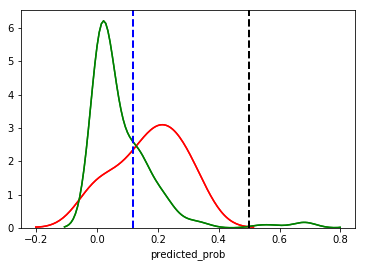

In [371]:
get_predictions(ypredp, y_test, thr=cutoff)

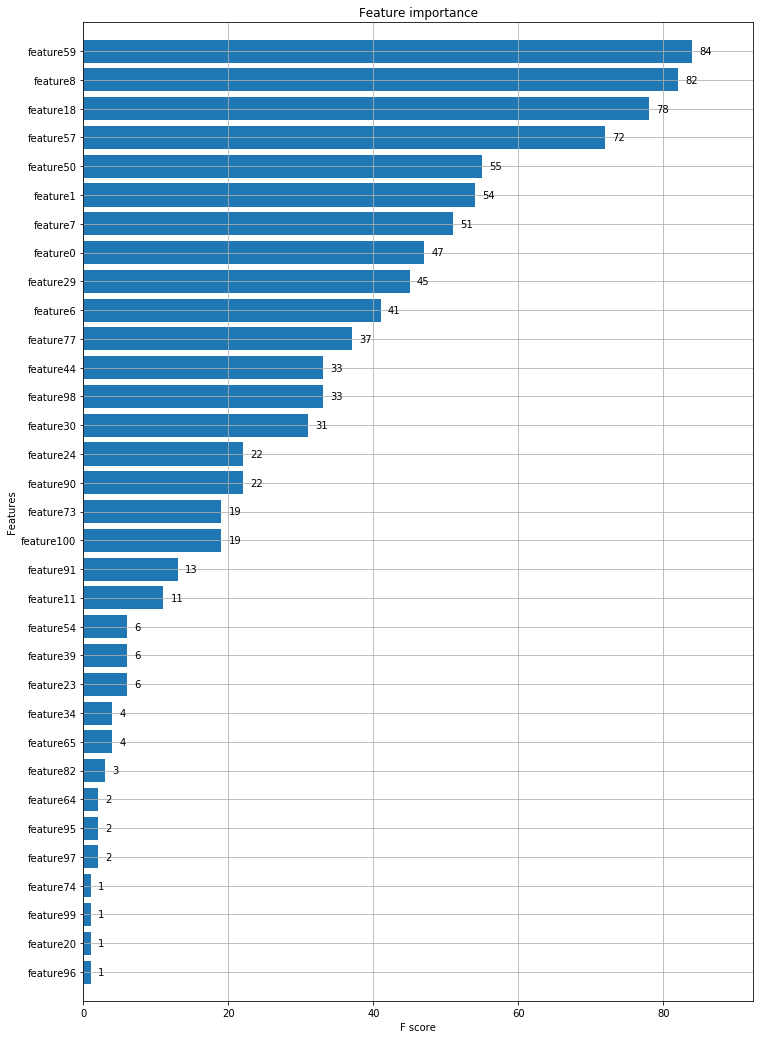

In [376]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb1, height=0.8, ax=ax)
plt.show()

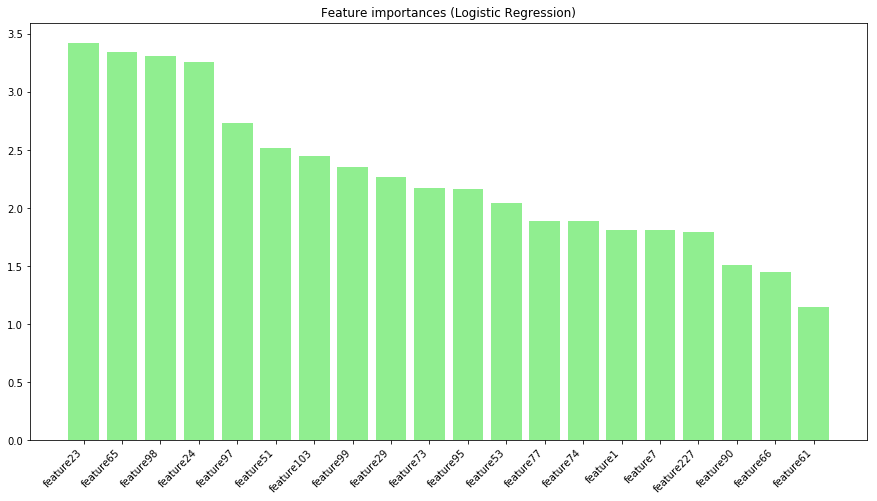

In [381]:
coefs = np.abs(lru.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize=(15,10))
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(20), coefs[indices[:20]],
       color="lightgreen", align="center")
plt.xticks(range(20), Xs_train.columns[indices[:20]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

#### ..
Both models have a very different opinion on important features! Need more data for a conclusive feature importance


#### A note
We cannot advise inspecting feature a is more worthwhile than inspecting feature b, 
since how "important" a feature is only makes sense in the context of a specific model being used, and not the real world. 

#### Find if there are any drastic changes in feature distribution in relation to label, this could be used to derive meta_features based on rules

In [58]:
v_features = list(data.columns[data.nunique() > 50])

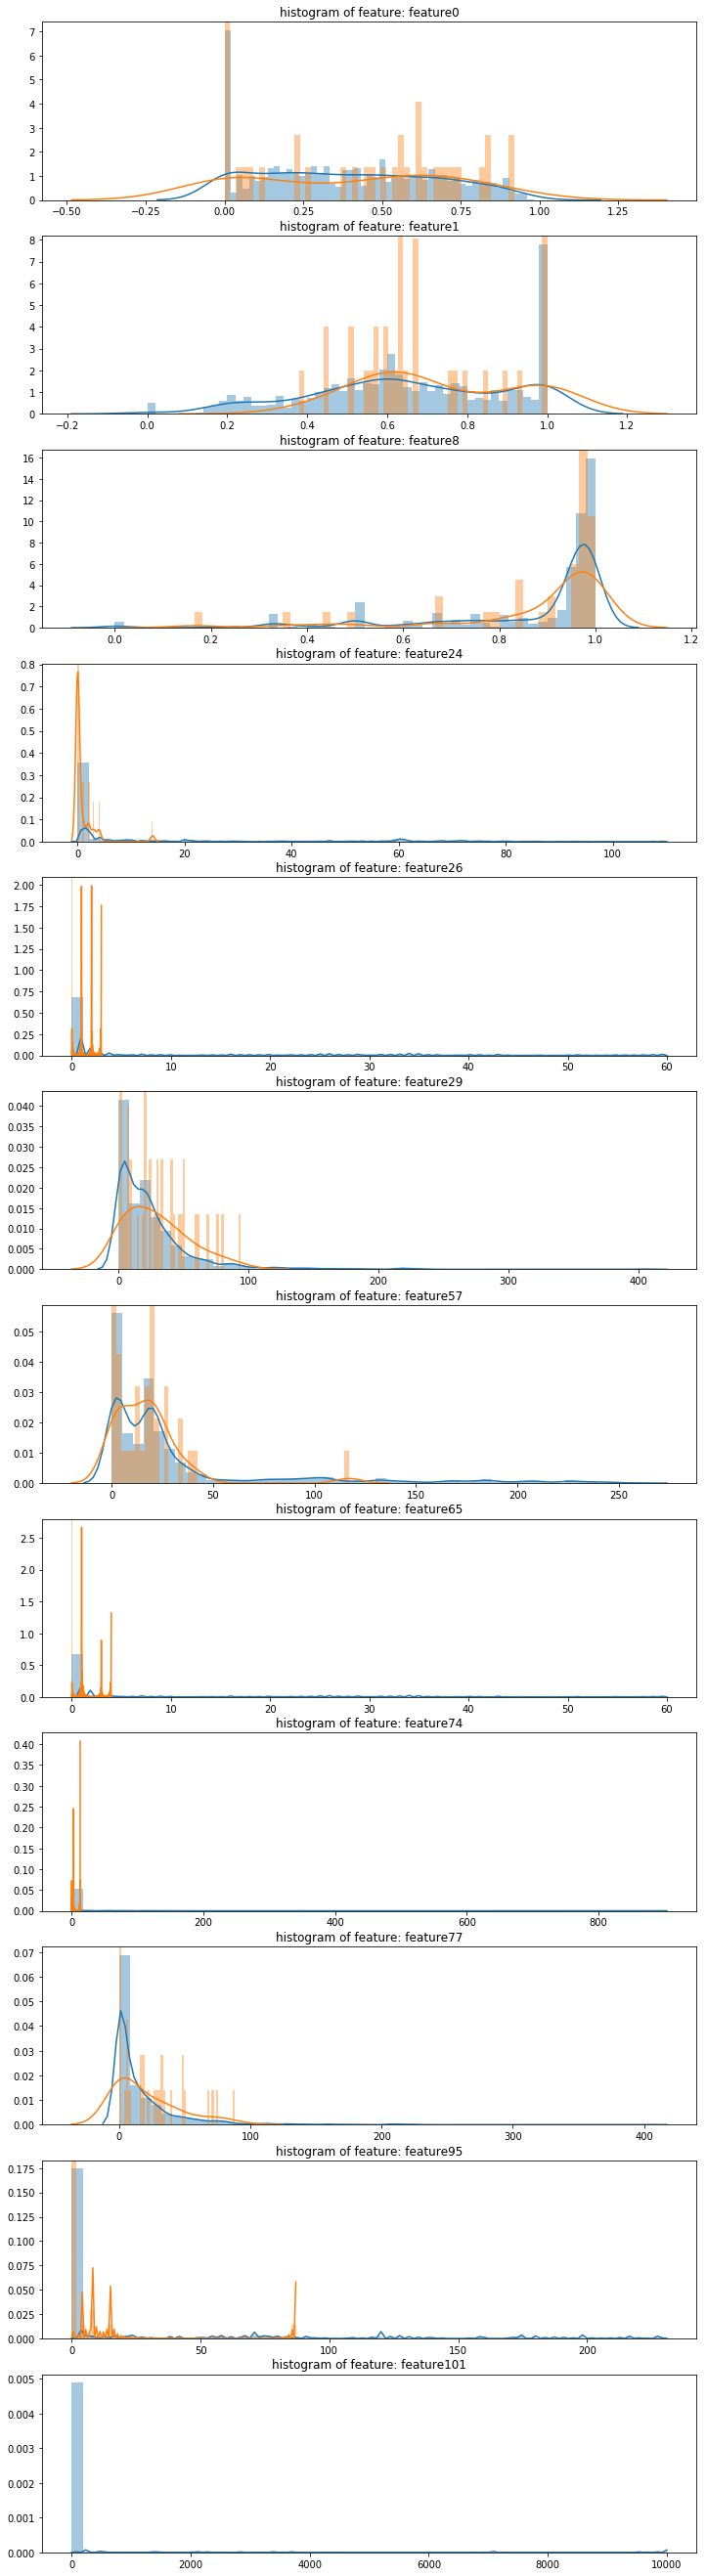

In [59]:

import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.label == 1], bins=50)
    sns.distplot(data[cn][data.label == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()



#### Nothing interesting here, except feature1 there are no changes in distribution 